# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import shutil
import os

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s5e3/train.csv'
    test_path = '/kaggle/input/playground-series-s5e3/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s5e3/sample_submission.csv'
    
    original_path = "/kaggle/input/hongkongrainfall/hongkong.csv"
    original_path_2 = "/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv"
    
    target = 'rainfall'
    n_folds = 10
    seed = 2100
    time_limit = 3600 * 11

    pipeline = 3

# Loading data and predefining folds

In [3]:
def get_data(pipeline):
    train = pd.read_csv(CFG.train_path, index_col="id")
    test = pd.read_csv(CFG.test_path, index_col="id")
    
    if pipeline == 1:
        return train, test, None
    
    original = pd.read_csv(CFG.original_path, encoding="gbk")
    original["date"] = pd.to_datetime(original[["year", "month", "day"]])
    original = original.drop(["year", "month", "day", "low visibility hour", "radiation", "evaporation"], axis=1)
    original["day"] = original.date.dt.dayofyear
    original = original.drop("date", axis=1)
    original.rainfall = original.rainfall.apply(lambda x: 1 if str(x).replace('.', '', 1).isdigit() else x)
    original.rainfall = original.rainfall.replace({'微量': 1, '-': 0}).astype(int)
    original.sunshine = original.sunshine.replace('-', 0).astype(float)
    for col in original.columns:
        original[col] = original[col].astype(train[col].dtype)
        
    if pipeline == 2:
        return train, test, original
        
    original_2 = pd.read_csv(CFG.original_path_2)
    original_2.columns = original_2.columns.str.replace(" ", "")
    original_2[CFG.target] = original_2[CFG.target].map({"yes": 1, "no": 0})
    original_2.day = original_2.index + 1
    for col in original_2.columns:
        original_2[col] = original_2[col].astype(train[col].dtype)
        
    if pipeline == 3:
        return train, test, original_2
        
    original_combined = pd.concat([original, original_2], axis=0).reset_index(drop=True)
    original_combined = original_combined.drop_duplicates().reset_index(drop=True)

    return train, test, original_combined

In [4]:
train, test, original = get_data(CFG.pipeline)

In [5]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    path='/AutoGluonModels',
    problem_type='binary',
    eval_metric='roc_auc',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

In [7]:
if original is None:
    predictor.fit(
        train_data=train,
        time_limit=CFG.time_limit,
        presets='best_quality'
    )
else:
    predictor.fit_pseudolabel(
        pseudo_data=original,
        train_data=train,
        time_limit=CFG.time_limit,
        presets='experimental_quality'
    )

Predictor not fit prior to pseudolabeling. Fitting now...
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.21 GB / 31.35 GB (96.4%)
Disk Space Avail:   1892.13 GB / 8062.39 GB (23.5%)
Presets specified: ['experimental_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subset

(_ray_fit pid=7750) [1000]	valid_set's binary_logloss: 0.303317
(_ray_fit pid=7879) [1000]	valid_set's binary_logloss: 0.346226 [repeated 8x across cluster]
(_ray_fit pid=8012) [1000]	valid_set's binary_logloss: 0.290323
(_ray_fit pid=8015) [1000]	valid_set's binary_logloss: 0.320026


(_dystack pid=166) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.99s	 = Training   runtime
(_dystack pid=166) 	0.29s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 4583.80s of the 7884.14s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8961	 = Validation score   (roc_auc)
(_dystack pid=166) 	36.3s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 4544.48s of the 7844.82s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.12%)
(_dystack pid=166) 	0.8885	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.25s	 = Training   runtime
(_dystack pid=

(autoscaler +34m35s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +34m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8856	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.99s	 = Training   runtime
(_dystack pid=166) 	0.8s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r137_BAG_L1 ... Training model for up to 4514.08s of the 7814.42s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8974	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.02s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r102_BAG_L1 ... Training model for up to 4498.14s of the 7798.48s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +35m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=9646) No improvement since epoch 2: early stopping


(autoscaler +35m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=10017) No improvement since epoch 2: early stopping
(_dystack pid=166) 	0.8982	 = Validation score   (roc_auc)
(_dystack pid=166) 	66.81s	 = Training   runtime
(_dystack pid=166) 	0.3s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r13_BAG_L1 ... Training model for up to 4428.36s of the 7728.70s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +36m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=166) 	29.74s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r195_BAG_L1 ... Training model for up to 4395.66s of the 7696.00s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +36m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8804	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.16s	 = Training   runtime
(_dystack pid=166) 	0.86s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r188_BAG_L1 ... Training model for up to 4373.53s of the 7673.87s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=166) 	0.895	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.92s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r145_BAG_L1 ... Training model for up to 4356.62s of the 7656.96s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +37m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=11303) No improvement since epoch 9: early stopping
(_ray_fit pid=11492) No improvement since epoch 7: early stopping
(_ray_fit pid=11494) No improvement since epoch 9: early stopping
(_ray_fit pid=11677) No improvement since epoch 10: early stopping
(_dystack pid=166) 	0.8918	 = Validation score   (roc_auc)
(_dystack pid=166) 	37.51s	 = Training   runtime
(_dystack pid=166) 	0.25s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r89_BAG_L1 ... Training model for up to 4316.14s of the 7616.48s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +38m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	8.87s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r30_BAG_L1 ... Training model for up to 4304.07s of the 7604.41s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +38m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.895	 = Validation score   (roc_auc)
(_dystack pid=166) 	57.22s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r130_BAG_L1 ... Training model for up to 4243.90s of the 7544.24s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +39m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8945	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.81s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r86_BAG_L1 ... Training model for up to 4228.02s of the 7528.36s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +39m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=166) 	32.19s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r50_BAG_L1 ... Training model for up to 4192.81s of the 7493.15s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.7s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r11_BAG_L1 ... Training model for up to 4176.22s of the 7476.56s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +40m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=13564) No improvement since epoch 6: early stopping
(_ray_fit pid=13777) No improvement since epoch 9: early stopping [repeated 3x across cluster]
(_ray_fit pid=13932) No improvement since epoch 10: early stopping
(_dystack pid=166) 	0.9003	 = Validation score   (roc_auc)
(_dystack pid=166) 	44.46s	 = Training   runtime
(_dystack pid=166) 	0.18s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r194_BAG_L1 ... Training model for up to 4128.92s of the 7429.26s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +41m16s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8865	 = Validation score   (roc_auc)
(_dystack pid=166) 	8.73s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r172_BAG_L1 ... Training model for up to 4117.14s of the 7417.48s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=166) 	10.94s	 = Training   runtime
(_dystack pid=166) 	0.89s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r69_BAG_L1 ... Training model for up to 4102.68s of the 7403.02s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8987	 = Validation scor

(autoscaler +41m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=15208) No improvement since epoch 16: early stopping
(_ray_fit pid=15392) No improvement since epoch 17: early stopping [repeated 2x across cluster]
(_ray_fit pid=15611) No improvement since epoch 20: early stopping [repeated 4x across cluster]
(_dystack pid=166) 	0.8954	 = Validation score   (roc_auc)
(_dystack pid=166) 	31.21s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r14_BAG_L1 ... Training model for up to 4053.09s of the 7353.43s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +42m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8975	 = Validation score   (roc_auc)
(_dystack pid=166) 	27.46s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r161_BAG_L1 ... Training model for up to 4022.25s of the 7322.59s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +43m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8902	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.31s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r143_BAG_L1 ... Training model for up to 4000.67s of the 7301.01s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8924	 = Validation score   (roc_auc)
(_dystack pid=166) 	24.09s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r70_BAG_L1 ... Training model for up to 3973.55s of the 7273.89s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +43m51s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8953	 = Validation score   (roc_auc)
(_dystack pid=166) 	20.87s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r156_BAG_L1 ... Training model for up to 3949.53s of the 7249.87s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +44m26s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=17239) No improvement since epoch 3: early stopping
(_ray_fit pid=17240) No improvement since epoch 16: early stopping
(_ray_fit pid=17237) No improvement since epoch 23: early stopping
(_ray_fit pid=17420) No improvement since epoch 3: early stopping


(autoscaler +45m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=17453) No improvement since epoch 3: early stopping
(_ray_fit pid=17499) No improvement since epoch 8: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.8932	 = Validation score   (roc_auc)
(_dystack pid=166) 	71.74s	 = Training   runtime
(_dystack pid=166) 	0.3s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r196_BAG_L1 ... Training model for up to 3874.86s of the 7175.20s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_ray_fit pid=17608) No improvement since epoch 4: early stopping


(_ray_fit pid=17705) [1000]	valid_set's binary_logloss: 0.331665
(_ray_fit pid=17707) [1000]	valid_set's binary_logloss: 0.312991
(autoscaler +45m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=17836) [1000]	valid_set's binary_logloss: 0.349358 [repeated 6x across cluster]
(_ray_fit pid=17966) [1000]	valid_set's binary_logloss: 0.294934 [repeated 3x across cluster]


(_dystack pid=166) 	0.897	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.4s	 = Training   runtime
(_dystack pid=166) 	0.52s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 3852.10s of the 7152.44s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8823	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.37s	 = Training   runtime
(_dystack pid=166) 	1.03s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 3831.75s of the 7132.09s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +46m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8944	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.09s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r95_BAG_L1 ... Training model for up to 3812.78s of the 7113.12s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +46m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=19075) No improvement since epoch 11: early stopping
(_ray_fit pid=19261) No improvement since epoch 10: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=166) 	38.22s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r41_BAG_L1 ... Training model for up to 3771.75s of the 7072.09s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +47m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8947	 = Validation score   (roc_auc)
(_dystack pid=166) 	39.14s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r98_BAG_L1 ... Training model for up to 3729.48s of the 7029.82s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +47m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8912	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.36s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r15_BAG_L1 ... Training model for up to 3712.69s of the 7013.03s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8932	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.84s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r158_BAG_L1 ... Training model for up to 3696.94s of the 6997.28s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +48m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.885	 = Validation score   (roc_auc)
(_dystack pid=166) 	40.97s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r86_BAG_L1 ... Training model for up to 3652.89s of the 6953.23s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +49m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8936	 = Validation score   (roc_auc)
(_dystack pid=166) 	21.31s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r37_BAG_L1 ... Training model for up to 3628.64s of the 6928.98s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +49m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=21524) No improvement since epoch 20: early stopping
(_dystack pid=166) 	0.8934	 = Validation score   (roc_auc)
(_dystack pid=166) 	28.3s	 = Training   runtime
(_dystack pid=166) 	0.2s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r197_BAG_L1 ... Training model for up to 3597.27s of the 6897.61s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +50m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8978	 = Validation score   (roc_auc)
(_dystack pid=166) 	25.1s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r49_BAG_L1 ... Training model for up to 3568.39s of the 6868.73s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8963	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.84s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r49_BAG_L1 ... Training model for up to 3552.56s of the 6852.90s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +50m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.886	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.74s	 = Training   runtime
(_dystack pid=166) 	0.86s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r143_BAG_L1 ... Training model for up to 3536.94s of the 6837.28s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=166) 	0.8851	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.59s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r127_BAG_L1 ... Training model for up to 3518.42s of the 6818.76s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +51m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8878	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.58s	 = Training   runtime
(_dystack pid=166) 	0.95s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r134_BAG_L1 ... Training model for up to 3495.80s of the 6796.14s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +52m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=23649) No improvement since epoch 16: early stopping
(_ray_fit pid=23648) No improvement since epoch 23: early stopping [repeated 2x across cluster]


(autoscaler +52m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=23897) No improvement since epoch 13: early stopping


(autoscaler +53m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=23833) No improvement since epoch 25: early stopping
(_ray_fit pid=23940) No improvement since epoch 22: early stopping
(_ray_fit pid=24051) No improvement since epoch 25: early stopping
(_dystack pid=166) 	0.8951	 = Validation score   (roc_auc)
(_dystack pid=166) 	127.72s	 = Training   runtime
(_dystack pid=166) 	0.34s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r34_BAG_L1 ... Training model for up to 3365.21s of the 6665.55s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +53m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8925	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.17s	 = Training   runtime
(_dystack pid=166) 	0.89s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r94_BAG_L1 ... Training model for up to 3348.93s of the 6649.27s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(_ray_fit pid=24584) [1000]	valid_set's binary_logloss: 0.294527 [repeated 5x across cluster]


(_dystack pid=166) 	0.8978	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.47s	 = Training   runtime
(_dystack pid=166) 	0.09s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r143_BAG_L1 ... Training model for up to 3332.43s of the 6632.77s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +54m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8929	 = Validation score   (roc_auc)
(_dystack pid=166) 	44.88s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r128_BAG_L1 ... Training model for up to 3284.47s of the 6584.81s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +55m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8928	 = Validation score   (roc_auc)
(_dystack pid=166) 	33.93s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r111_BAG_L1 ... Training model for up to 3247.32s of the 6547.66s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +55m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +56m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8957	 = Validation score   (roc_auc)
(_dystack pid=166) 	58.43s	 = Training   runtime
(_dystack pid=166) 	0.36s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r31_BAG_L1 ... Training model for up to 3186.04s of the 6486.38s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +57m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.895	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.81s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r4_BAG_L1 ... Training model for up to 3152.18s of the 6452.52s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8926	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.48s	 = Training   runtime
(_dystack pid=166) 	1.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r65_BAG_L1 ... Training model for up to 3136.61s of the 6436.95s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +57m48s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8895	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.33s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r88_BAG_L1 ... Training model for up to 3110.51s of the 6410.85s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=27436) No improvement since epoch 4: early stopping


(autoscaler +58m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=27621) No improvement since epoch 4: early stopping [repeated 4x across cluster]
(_dystack pid=166) 	0.8739	 = Validation score   (roc_auc)
(_dystack pid=166) 	22.65s	 = Training   runtime
(_dystack pid=166) 	0.2s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r30_BAG_L1 ... Training model for up to 3084.12s of the 6384.46s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_ray_fit pid=27619) No improvement since epoch 5: early stopping [repeated 3x across cluster]


(_ray_fit pid=27905) [1000]	valid_set's binary_logloss: 0.296375
(_ray_fit pid=27904) [1000]	valid_set's binary_logloss: 0.304081
(_ray_fit pid=28170) [1000]	valid_set's binary_logloss: 0.317417


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.31s	 = Training   runtime
(_dystack pid=166) 	0.16s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r49_BAG_L1 ... Training model for up to 3065.60s of the 6365.94s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +58m59s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8913	 = Validation score   (roc_auc)
(_dystack pid=166) 	9.64s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r5_BAG_L1 ... Training model for up to 3053.14s of the 6353.48s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.68s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r87_BAG_L1 ... Training model for up to 3037.69s of the 6338.03s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +59m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8969	 = Validation score   (roc_auc)
(_dystack pid=166) 	39.94s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r71_BAG_L1 ... Training model for up to 2994.95s of the 6295.29s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.98s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r143_BAG_L1 ... Training model for up to 2967.88s of the 6268.22s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +1h44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8955	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.12s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r178_BAG_L1 ... Training model for up to 2949.66s of the 6250.00s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8912	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.85s	 = Training   runtime
(_dystack pid=166) 	0.97s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r166_BAG_L1 ... Training model for up to 2932.43s of the 6232.77s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 wo

(autoscaler +1h1m19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8824	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.2s	 = Training   runtime
(_dystack pid=166) 	0.92s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r31_BAG_L1 ... Training model for up to 2911.33s of the 6211.67s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=166) 	10.13s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r185_BAG_L1 ... Training model for up to 2898.33s of the 6198.67s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h1m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8924	 = Validation score   (roc_auc)
(_dystack pid=166) 	33.98s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r160_BAG_L1 ... Training model for up to 2861.51s of the 6161.85s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h2m29s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.897	 = Validation score   (roc_auc)
(_dystack pid=166) 	31.77s	 = Training   runtime
(_dystack pid=166) 	0.16s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r60_BAG_L1 ... Training model for up to 2826.59s of the 6126.93s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h3m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8984	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.96s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r15_BAG_L1 ... Training model for up to 2809.37s of the 6109.71s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8847	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.11s	 = Training   runtime
(_dystack pid=166) 	0.87s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r135_BAG_L1 ... Training model for up to 2788.27s of the 6088.61s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.05%)


(autoscaler +1h3m39s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8911	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.72s	 = Training   runtime
(_dystack pid=166) 	0.04s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r22_BAG_L1 ... Training model for up to 2771.46s of the 6071.80s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.8915	 = Validation score   (roc_auc)
(_dystack pid=166) 	8.43s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r69_BAG_L1 ... Training model for up to 2759.91s of the 6060.25s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h4m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8957	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.71s	 = Training   runtime
(_dystack pid=166) 	0.19s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r6_BAG_L1 ... Training model for up to 2726.16s of the 6026.50s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8962	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.03s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r138_BAG_L1 ... Training model for up to 2709.79s of the 6010.13s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h4m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=34534) No improvement since epoch 16: early stopping


(autoscaler +1h5m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=34810) No improvement since epoch 14: early stopping [repeated 3x across cluster]
(_ray_fit pid=34905) No improvement since epoch 15: early stopping [repeated 4x across cluster]
(_dystack pid=166) 	0.8916	 = Validation score   (roc_auc)
(_dystack pid=166) 	53.33s	 = Training   runtime
(_dystack pid=166) 	0.23s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r121_BAG_L1 ... Training model for up to 2653.56s of the 5953.90s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.05%)
(_dystack pid=166) 	0.8893	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.11s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r172_BAG_L1 ... Training model for up to 2632.48s of the 5932.82s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with Paral

(autoscaler +1h6m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=35339) No improvement since epoch 8: early stopping
(_ray_fit pid=35525) No improvement since epoch 4: early stopping [repeated 3x across cluster]
(_ray_fit pid=35710) No improvement since epoch 11: early stopping
(_dystack pid=166) 	0.8917	 = Validation score   (roc_auc)
(_dystack pid=166) 	24.93s	 = Training   runtime
(_dystack pid=166) 	0.17s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r180_BAG_L1 ... Training model for up to 2604.47s of the 5904.81s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)


(autoscaler +1h6m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8966	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.97s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r76_BAG_L1 ... Training model for up to 2574.37s of the 5874.71s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h7m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8953	 = Validation score   (roc_auc)
(_dystack pid=166) 	25.74s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r197_BAG_L1 ... Training model for up to 2545.74s of the 5846.08s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8856	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.77s	 = Training   runtime
(_dystack pid=166) 	0.93s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r121_BAG_L1 ... Training model for up to 2526.85s of the 5827.19s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h7m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.888	 = Validation score   (roc_auc)
(_dystack pid=166) 	43.86s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r127_BAG_L1 ... Training model for up to 2479.84s of the 5780.18s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h8m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.891	 = Validation score   (roc_auc)
(_dystack pid=166) 	22.71s	 = Training   runtime
(_dystack pid=166) 	0.21s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r16_BAG_L1 ... Training model for up to 2454.12s of the 5754.46s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h9m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8789	 = Validation score   (roc_auc)
(_dystack pid=166) 	25.27s	 = Training   runtime
(_dystack pid=166) 	0.94s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r194_BAG_L1 ... Training model for up to 2425.64s of the 5725.98s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h9m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8934	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.74s	 = Training   runtime
(_dystack pid=166) 	0.14s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r12_BAG_L1 ... Training model for up to 2396.02s of the 5696.36s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=166) 	0.8961	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.72s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r135_BAG_L1 ... Training model for up to 2373.59s of the 5673.93s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h10m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8954	 = Validation score   (roc_auc)
(_dystack pid=166) 	43.54s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r4_BAG_L1 ... Training model for up to 2327.14s of the 5627.48s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h11m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=39736) No improvement since epoch 18: early stopping
(_ray_fit pid=39920) No improvement since epoch 11: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.8959	 = Validation score   (roc_auc)
(_dystack pid=166) 	27.6s	 = Training   runtime
(_dystack pid=166) 	0.16s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r126_BAG_L1 ... Training model for up to 2296.29s of the 5596.63s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h11m51s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8901	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.95s	 = Training   runtime
(_dystack pid=166) 	0.88s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r36_BAG_L1 ... Training model for up to 2280.14s of the 5580.48s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h12m26s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8956	 = Validation score   (roc_auc)
(_dystack pid=166) 	37.65s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r100_BAG_L1 ... Training model for up to 2239.46s of the 5539.80s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h13m1s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=40848) No improvement since epoch 9: early stopping
(_ray_fit pid=40850) No improvement since epoch 14: early stopping [repeated 2x across cluster]


(autoscaler +1h13m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=41095) No improvement since epoch 7: early stopping
(_ray_fit pid=41034) No improvement since epoch 13: early stopping
(_dystack pid=166) 	0.8855	 = Validation score   (roc_auc)
(_dystack pid=166) 	105.52s	 = Training   runtime
(_dystack pid=166) 	0.42s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r163_BAG_L1 ... Training model for up to 2130.90s of the 5431.24s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=41128) No improvement since epoch 10: early stopping [repeated 2x across cluster]


(autoscaler +1h14m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8977	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.03s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r198_BAG_L1 ... Training model for up to 2115.64s of the 5415.98s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.8966	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.47s	 = Training   runtime
(_dystack pid=166) 	0.02s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r187_BAG_L1 ... Training model for up to 2098.32s of the 5398.66s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h15m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.89	 = Validation score   (roc_auc)
(_dystack pid=166) 	24.0s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r19_BAG_L1 ... Training model for up to 2071.42s of the 5371.76s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h15m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8941	 = Validation score   (roc_auc)
(_dystack pid=166) 	24.6s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r95_BAG_L1 ... Training model for up to 2043.46s of the 5343.80s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.892	 = Validation score   (roc_auc)
(_dystack pid=166) 	9.0s	 = Training   runtime
(_dystack pid=166) 	0.08s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r34_BAG_L1 ... Training model for up to 2031.47s of the 5331.81s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.11%)


(autoscaler +1h16m16s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8907	 = Validation score   (roc_auc)
(_dystack pid=166) 	9.81s	 = Training   runtime
(_dystack pid=166) 	0.09s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r42_BAG_L1 ... Training model for up to 2018.85s of the 5319.19s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.05%)
(_dystack pid=166) 	0.8972	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.87s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r1_BAG_L1 ... Training model for up to 2003.11s of the 5303.45s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h16m51s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8903	 = Validation score   (roc_auc)
(_dystack pid=166) 	34.54s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r89_BAG_L1 ... Training model for up to 1965.60s of the 5265.94s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)


(autoscaler +1h17m26s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8935	 = Validation score   (roc_auc)
(_dystack pid=166) 	39.85s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: WeightedEnsemble_L2 ... Training model for up to 659.57s of the 5223.18s of remaining time.
(_dystack pid=166) 	Ensemble Weights: {'CatBoost_r50_BAG_L1': 0.4, 'NeuralNetFastAI_r11_BAG_L1': 0.28, 'NeuralNetTorch_r197_BAG_L1': 0.12, 'KNeighborsDist_BAG_L1': 0.04, 'NeuralNetFastAI_r102_BAG_L1': 0.04, 'XGBoost_r89_BAG_L1': 0.04, 'CatBoost_r69_BAG_L1': 0.04, 'NeuralNetTorch_r14_BAG_L1': 0.04}
(_dystack pid=166) 	0.9061	 = Validation score   (roc_auc)
(_dystack pid=166) 	0.2s	 = Training   runtime
(_dystack pid=166) 	0.0s	 = Validation runtime
(_dystack pid=166) Fitting 109 L2 models, fit_strategy="parallel" ...
(_dystack pid=166) Note: fit_strategy='parallel', but `num_cpus=4`. Running parallel mode with fewer than 12 CPUs is not recommended and has been disabled. You can override this by specifying `os.

(autoscaler +1h18m1s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9046	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.32s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_BAG_L2 ... Training model for up to 5205.86s of the 5205.60s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)
(_dystack pid=166) 	0.8983	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.97s	 = Training   runtime
(_dystack pid=166) 	0.03s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForestGini_BAG_L2 ... Training model for up to 5187.77s of the 5187.51s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h18m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.19s	 = Training   runtime
(_dystack pid=166) 	1.0s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForestEntr_BAG_L2 ... Training model for up to 5168.45s of the 5168.19s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.9016	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.17s	 = Training   runtime
(_dystack pid=166) 	0.94s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_BAG_L2 ... Training model for up to 5149.18s of the 5148.92s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)


(autoscaler +1h19m17s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9054	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.22s	 = Training   runtime
(_dystack pid=166) 	0.04s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTreesGini_BAG_L2 ... Training model for up to 5122.92s of the 5122.66s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8962	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.89s	 = Training   runtime
(_dystack pid=166) 	0.86s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTreesEntr_BAG_L2 ... Training model for up to 5108.09s of the 5107.83s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 worker

(autoscaler +1h19m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9012	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.39s	 = Training   runtime
(_dystack pid=166) 	0.86s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 5093.59s of the 5093.33s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=166) 	0.8991	 = Validation score   (roc_auc)
(_dystack pid=166) 	27.84s	 = Training   runtime
(_dystack pid=166) 	0.21s	 = Validation runtime
(_dystack pid=166) Fitting model: TabPFNMix_v1_BAG_L2 ... Training model for up to 5062.85s of the 5062.59s of remaining time.
(_dystack pid=166) 	Memory not enough to fit 10 folds in parallel. Will train 2 folds in parallel instead (Estimated 28.27% memory usage per fold, 56.53%/80.00% total).
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (

(autoscaler +1h20m42s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h21m17s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h21m52s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h22m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 2.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9035	 = Validation score   (roc_auc)
(_dystack pid=166) 	1759.1s	 = Training   runtime
(_dystack pid=166) 	39.08s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_BAG_L2 ... Training model for up to 3299.39s of the 3299.14s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.19%)


(autoscaler +1h50m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9025	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.0s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_BAG_L2 ... Training model for up to 3285.29s of the 3285.03s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h50m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.903	 = Validation score   (roc_auc)
(_dystack pid=166) 	34.26s	 = Training   runtime
(_dystack pid=166) 	0.35s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 3248.07s of the 3247.81s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)
(_dystack pid=166) 	0.8858	 = Validation score   (roc_auc)
(_dystack pid=166) 	22.03s	 = Training   runtime
(_dystack pid=166) 	0.04s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r177_BAG_L2 ... Training model for up to 3222.99s of the 3222.73s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)


(autoscaler +1h51m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9053	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.65s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r79_BAG_L2 ... Training model for up to 3200.20s of the 3199.94s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h51m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9039	 = Validation score   (roc_auc)
(_dystack pid=166) 	48.01s	 = Training   runtime
(_dystack pid=166) 	0.28s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r131_BAG_L2 ... Training model for up to 3149.18s of the 3148.92s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.15%)


(autoscaler +1h52m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.03s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r191_BAG_L2 ... Training model for up to 3129.16s of the 3128.90s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=50556) No improvement since epoch 12: early stopping


(autoscaler +1h53m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=50742) No improvement since epoch 13: early stopping [repeated 3x across cluster]
(_ray_fit pid=50933) No improvement since epoch 10: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	0.8957	 = Validation score   (roc_auc)
(_dystack pid=166) 	39.2s	 = Training   runtime
(_dystack pid=166) 	0.17s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r9_BAG_L2 ... Training model for up to 3086.83s of the 3086.58s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +1h53m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h54m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9037	 = Validation score   (roc_auc)
(_dystack pid=166) 	79.1s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r96_BAG_L2 ... Training model for up to 3004.82s of the 3004.56s of remaining time.
(_ray_fit pid=50931) No improvement since epoch 18: early stopping
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h54m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=51416) [1000]	valid_set's binary_logloss: 0.272396
(_ray_fit pid=51540) [1000]	valid_set's binary_logloss: 0.335796
(_ray_fit pid=51540) [2000]	valid_set's binary_logloss: 0.335077


(_dystack pid=166) 	0.9044	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.09s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 2987.86s of the 2987.60s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h55m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9051	 = Validation score   (roc_auc)
(_dystack pid=166) 	49.58s	 = Training   runtime
(_dystack pid=166) 	0.31s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 2935.31s of the 2935.05s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.25%)


(autoscaler +1h56m7s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9028	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.74s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r42_BAG_L2 ... Training model for up to 2914.74s of the 2914.48s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.899	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.95s	 = Training   runtime
(_dystack pid=166) 	0.9s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r137_BAG_L2 ... Training model for up to 2898.76s of the 2898.50s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +1h56m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9044	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.47s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r102_BAG_L2 ... Training model for up to 2881.01s of the 2880.75s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h57m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=53304) No improvement since epoch 3: early stopping
(_ray_fit pid=53523) No improvement since epoch 6: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.9048	 = Validation score   (roc_auc)
(_dystack pid=166) 	65.51s	 = Training   runtime
(_dystack pid=166) 	0.33s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r13_BAG_L2 ... Training model for up to 2812.62s of the 2812.36s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +1h58m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h58m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9039	 = Validation score   (roc_auc)
(_dystack pid=166) 	65.71s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r195_BAG_L2 ... Training model for up to 2743.70s of the 2743.44s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +1h59m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8953	 = Validation score   (roc_auc)
(_dystack pid=166) 	34.6s	 = Training   runtime
(_dystack pid=166) 	1.27s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r188_BAG_L2 ... Training model for up to 2706.18s of the 2705.92s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)


(autoscaler +1h59m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9016	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.78s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r145_BAG_L2 ... Training model for up to 2688.34s of the 2688.09s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=55151) No improvement since epoch 10: early stopping
(_ray_fit pid=55336) No improvement since epoch 10: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	0.8998	 = Validation score   (roc_auc)
(_dystack pid=166) 	37.01s	 = Training   runtime
(_dystack pid=166) 	0.23s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r89_BAG_L2 ... Training model for up to 2648.34s of the 2648.08s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=166) 	0.9018	 = Validation score   (roc_auc)
(_dystack pid=166) 	10.03s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r30_BAG_L2 ... Training model for up to 2635.23s of the 2634.98s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 wo

(autoscaler +2h1m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +2h1m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8983	 = Validation score   (roc_auc)
(_dystack pid=166) 	62.35s	 = Training   runtime
(_dystack pid=166) 	0.28s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r130_BAG_L2 ... Training model for up to 2569.98s of the 2569.73s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.23%)


(autoscaler +2h2m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9008	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.84s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r86_BAG_L2 ... Training model for up to 2553.07s of the 2552.81s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=166) 	32.59s	 = Training   runtime
(_dystack pid=166) 	0.52s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r50_BAG_L2 ... Training model for up to 2517.52s of the 2517.26s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +2h3m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9055	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.52s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r11_BAG_L2 ... Training model for up to 2495.92s of the 2495.66s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h3m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=57597) No improvement since epoch 7: early stopping
(_dystack pid=166) 	0.8996	 = Validation score   (roc_auc)
(_dystack pid=166) 	43.64s	 = Training   runtime
(_dystack pid=166) 	0.21s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r194_BAG_L2 ... Training model for up to 2449.57s of the 2449.31s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.34%)


(autoscaler +2h4m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9023	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.23s	 = Training   runtime
(_dystack pid=166) 	0.17s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r172_BAG_L2 ... Training model for up to 2435.32s of the 2435.06s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.9009	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.64s	 = Training   runtime
(_dystack pid=166) 	0.94s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r69_BAG_L2 ... Training model for up to 2420.69s of the 2420.44s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +2h4m53s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9069	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.72s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r103_BAG_L2 ... Training model for up to 2401.06s of the 2400.80s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=58881) No improvement since epoch 14: early stopping
(_ray_fit pid=59067) No improvement since epoch 18: early stopping [repeated 3x across cluster]
(_ray_fit pid=59254) No improvement since epoch 10: early stopping
(_ray_fit pid=59252) No improvement since epoch 13: early stopping
(_dystack pid=166) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.68s	 = Training   runtime
(_dystack pid=166) 	0.14s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r14_BAG_L2 ... Training model for up to 2367.56s of t

(autoscaler +2h5m38s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9011	 = Validation score   (roc_auc)
(_dystack pid=166) 	28.28s	 = Training   runtime
(_dystack pid=166) 	0.28s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r161_BAG_L2 ... Training model for up to 2336.12s of the 2335.86s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +2h6m13s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.903	 = Validation score   (roc_auc)
(_dystack pid=166) 	22.26s	 = Training   runtime
(_dystack pid=166) 	0.2s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r143_BAG_L2 ... Training model for up to 2310.58s of the 2310.32s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=60054) No improvement since epoch 3: early stopping


(autoscaler +2h6m48s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=60237) No improvement since epoch 2: early stopping
(_dystack pid=166) 	0.8806	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.2s	 = Training   runtime
(_dystack pid=166) 	0.18s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r70_BAG_L2 ... Training model for up to 2284.40s of the 2284.14s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)


(autoscaler +2h7m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9068	 = Validation score   (roc_auc)
(_dystack pid=166) 	39.54s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r156_BAG_L2 ... Training model for up to 2241.19s of the 2240.93s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h7m59s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=60908) No improvement since epoch 23: early stopping


(autoscaler +2h8m34s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=61150) No improvement since epoch 5: early stopping [repeated 2x across cluster]
(_ray_fit pid=61308) No improvement since epoch 10: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	0.9004	 = Validation score   (roc_auc)
(_dystack pid=166) 	74.21s	 = Training   runtime
(_dystack pid=166) 	0.35s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r196_BAG_L2 ... Training model for up to 2164.17s of the 2163.91s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.34%)


(_ray_fit pid=61373) [1000]	valid_set's binary_logloss: 0.300645 [repeated 2x across cluster]
(autoscaler +2h9m9s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(_ray_fit pid=61505) [1000]	valid_set's binary_logloss: 0.336684 [repeated 2x across cluster]
(_ray_fit pid=61636) [1000]	valid_set's binary_logloss: 0.286128 [repeated 2x across cluster]


(_dystack pid=166) 	0.9023	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.48s	 = Training   runtime
(_dystack pid=166) 	0.35s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r39_BAG_L2 ... Training model for up to 2141.58s of the 2141.32s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +2h9m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8962	 = Validation score   (roc_auc)
(_dystack pid=166) 	31.97s	 = Training   runtime
(_dystack pid=166) 	1.01s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r167_BAG_L2 ... Training model for up to 2106.69s of the 2106.43s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.32%)
(_dystack pid=166) 	0.9016	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.73s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r95_BAG_L2 ... Training model for up to 2077.10s of the 2076.84s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h10m29s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=62569) No improvement since epoch 11: early stopping
(_ray_fit pid=62756) No improvement since epoch 10: early stopping
(_ray_fit pid=62754) No improvement since epoch 10: early stopping
(_ray_fit pid=62941) No improvement since epoch 9: early stopping
(_dystack pid=166) 	0.8983	 = Validation score   (roc_auc)
(_dystack pid=166) 	37.01s	 = Training   runtime
(_dystack pid=166) 	0.33s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r41_BAG_L2 ... Training model for up to 2037.24s of the 2036.98s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h11m4s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.905	 = Validation score   (roc_auc)
(_dystack pid=166) 	35.13s	 = Training   runtime
(_dystack pid=166) 	0.28s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r98_BAG_L2 ... Training model for up to 1998.93s of the 1998.67s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.64%)


(autoscaler +2h11m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9022	 = Validation score   (roc_auc)
(_dystack pid=166) 	20.13s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r15_BAG_L2 ... Training model for up to 1975.80s of the 1975.54s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.07%)
(_dystack pid=166) 	0.9038	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.84s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r158_BAG_L2 ... Training model for up to 1958.07s of the 1957.82s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h12m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.898	 = Validation score   (roc_auc)
(_dystack pid=166) 	51.16s	 = Training   runtime
(_dystack pid=166) 	0.31s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r86_BAG_L2 ... Training model for up to 1903.71s of the 1903.46s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +2h13m19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +2h13m54s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9034	 = Validation score   (roc_auc)
(_dystack pid=166) 	48.48s	 = Training   runtime
(_dystack pid=166) 	0.04s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r37_BAG_L2 ... Training model for up to 1852.33s of the 1852.07s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h14m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=65013) No improvement since epoch 14: early stopping
(_ray_fit pid=65201) No improvement since epoch 20: early stopping
(_ray_fit pid=65203) No improvement since epoch 18: early stopping
(_dystack pid=166) 	0.9017	 = Validation score   (roc_auc)
(_dystack pid=166) 	28.6s	 = Training   runtime
(_dystack pid=166) 	0.26s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r197_BAG_L2 ... Training model for up to 1820.80s of the 1820.54s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.6s	 = Training   runtime
(_dystack pid=166) 	0.3s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r49_BAG_L2 ... Training model for up to 1790.90s of the 1790.65s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with P

(autoscaler +2h15m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.904	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.84s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r49_BAG_L2 ... Training model for up to 1774.26s of the 1774.00s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8962	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.32s	 = Training   runtime
(_dystack pid=166) 	0.82s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r143_BAG_L2 ... Training model for up to 1758.00s of the 1757.74s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.44%)


(autoscaler +2h15m50s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.13s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r127_BAG_L2 ... Training model for up to 1735.90s of the 1735.64s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +2h16m25s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8983	 = Validation score   (roc_auc)
(_dystack pid=166) 	37.15s	 = Training   runtime
(_dystack pid=166) 	1.1s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r134_BAG_L2 ... Training model for up to 1695.69s of the 1695.43s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h17m0s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=67312) No improvement since epoch 9: early stopping
(_ray_fit pid=67313) No improvement since epoch 17: early stopping
(_ray_fit pid=67315) No improvement since epoch 23: early stopping


(autoscaler +2h17m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +2h18m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=67495) No improvement since epoch 26: early stopping [repeated 2x across cluster]
(_ray_fit pid=67606) No improvement since epoch 22: early stopping [repeated 2x across cluster]
(_ray_fit pid=67682) No improvement since epoch 25: early stopping
(_dystack pid=166) 	0.9037	 = Validation score   (roc_auc)
(_dystack pid=166) 	122.83s	 = Training   runtime
(_dystack pid=166) 	0.35s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r34_BAG_L2 ... Training model for up to 1569.93s of the 1569.68s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +2h18m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9005	 = Validation score   (roc_auc)
(_dystack pid=166) 	20.46s	 = Training   runtime
(_dystack pid=166) 	1.06s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r94_BAG_L2 ... Training model for up to 1546.21s of the 1545.96s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(_ray_fit pid=68245) [1000]	valid_set's binary_logloss: 0.268123 [repeated 2x across cluster]


(_dystack pid=166) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.52s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r143_BAG_L2 ... Training model for up to 1529.90s of the 1529.64s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h19m35s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +2h20m10s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9	 = Validation score   (roc_auc)
(_dystack pid=166) 	50.24s	 = Training   runtime
(_dystack pid=166) 	0.31s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r128_BAG_L2 ... Training model for up to 1476.53s of the 1476.27s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.63%)


(autoscaler +2h20m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +2h21m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9035	 = Validation score   (roc_auc)
(_dystack pid=166) 	79.4s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r111_BAG_L2 ... Training model for up to 1394.12s of the 1393.86s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h21m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +2h22m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9009	 = Validation score   (roc_auc)
(_dystack pid=166) 	57.49s	 = Training   runtime
(_dystack pid=166) 	0.33s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r31_BAG_L2 ... Training model for up to 1333.81s of the 1333.55s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h23m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9009	 = Validation score   (roc_auc)
(_dystack pid=166) 	34.92s	 = Training   runtime
(_dystack pid=166) 	0.3s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r4_BAG_L2 ... Training model for up to 1295.73s of the 1295.47s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.9007	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.06s	 = Training   runtime
(_dystack pid=166) 	0.82s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r65_BAG_L2 ... Training model for up to 1280.61s of the 1280.36s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h23m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8947	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.78s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r88_BAG_L2 ... Training model for up to 1253.88s of the 1253.62s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_ray_fit pid=71104) No improvement since epoch 1: early stopping


(autoscaler +2h24m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=71294) No improvement since epoch 1: early stopping [repeated 4x across cluster]
(_dystack pid=166) 	0.8758	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.11s	 = Training   runtime
(_dystack pid=166) 	0.38s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r30_BAG_L2 ... Training model for up to 1227.60s of the 1227.34s of remaining time.
(_ray_fit pid=71292) No improvement since epoch 7: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.29%)


(_ray_fit pid=71572) [1000]	valid_set's binary_logloss: 0.267434
(_ray_fit pid=71706) [1000]	valid_set's binary_logloss: 0.335404


(_dystack pid=166) 	0.9037	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.15s	 = Training   runtime
(_dystack pid=166) 	0.19s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r49_BAG_L2 ... Training model for up to 1208.14s of the 1207.88s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.34%)


(autoscaler +2h24m56s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.82s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r5_BAG_L2 ... Training model for up to 1193.34s of the 1193.08s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=166) 	0.9055	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.35s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r87_BAG_L2 ... Training model for up to 1176.05s of the 1175.79s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h25m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9001	 = Validation score   (roc_auc)
(_dystack pid=166) 	35.95s	 = Training   runtime
(_dystack pid=166) 	0.38s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r71_BAG_L2 ... Training model for up to 1137.29s of the 1137.03s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h26m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9013	 = Validation score   (roc_auc)
(_dystack pid=166) 	24.64s	 = Training   runtime
(_dystack pid=166) 	0.28s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r143_BAG_L2 ... Training model for up to 1109.68s of the 1109.42s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)


(autoscaler +2h26m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9016	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.62s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r178_BAG_L2 ... Training model for up to 1079.94s of the 1079.68s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.901	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.12s	 = Training   runtime
(_dystack pid=166) 	0.84s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r166_BAG_L2 ... Training model for up to 1062.82s of the 1062.56s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 wor

(autoscaler +2h27m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.97s	 = Training   runtime
(_dystack pid=166) 	0.9s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r31_BAG_L2 ... Training model for up to 1039.76s of the 1039.50s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=166) 	0.9032	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.19s	 = Training   runtime
(_dystack pid=166) 	0.16s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r185_BAG_L2 ... Training model for up to 1023.52s of the 1023.26s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h28m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8957	 = Validation score   (roc_auc)
(_dystack pid=166) 	40.92s	 = Training   runtime
(_dystack pid=166) 	0.34s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r160_BAG_L2 ... Training model for up to 979.67s of the 979.41s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h28m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8989	 = Validation score   (roc_auc)
(_dystack pid=166) 	32.71s	 = Training   runtime
(_dystack pid=166) 	0.32s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r60_BAG_L2 ... Training model for up to 943.84s of the 943.58s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +2h29m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9063	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.79s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r15_BAG_L2 ... Training model for up to 922.77s of the 922.51s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +2h29m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	32.07s	 = Training   runtime
(_dystack pid=166) 	1.07s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r135_BAG_L2 ... Training model for up to 887.46s of the 887.20s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.52%)
(_dystack pid=166) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.6s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r22_BAG_L2 ... Training model for up to 868.70s of the 868.44s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)


(autoscaler +2h30m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9011	 = Validation score   (roc_auc)
(_dystack pid=166) 	9.9s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r69_BAG_L2 ... Training model for up to 855.67s of the 855.41s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)
(_dystack pid=166) 	0.9023	 = Validation score   (roc_auc)
(_dystack pid=166) 	31.27s	 = Training   runtime
(_dystack pid=166) 	0.3s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r6_BAG_L2 ... Training model for up to 821.05s of the 820.79s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)


(autoscaler +2h31m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9067	 = Validation score   (roc_auc)
(_dystack pid=166) 	18.33s	 = Training   runtime
(_dystack pid=166) 	0.06s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r138_BAG_L2 ... Training model for up to 799.69s of the 799.43s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h31m57s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=78232) No improvement since epoch 9: early stopping
(_ray_fit pid=78479) No improvement since epoch 6: early stopping [repeated 4x across cluster]
(_ray_fit pid=78603) No improvement since epoch 10: early stopping [repeated 4x across cluster]
(_dystack pid=166) 	0.8922	 = Validation score   (roc_auc)
(_dystack pid=166) 	48.36s	 = Training   runtime
(_dystack pid=166) 	0.22s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r121_BAG_L2 ... Training model for up to 748.47s of the 748.21s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.53%)


(autoscaler +2h32m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.903	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.5s	 = Training   runtime
(_dystack pid=166) 	0.13s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r172_BAG_L2 ... Training model for up to 721.85s of the 721.59s of remaining time.
(_ray_fit pid=78601) No improvement since epoch 17: early stopping
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h33m12s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=79407) No improvement since epoch 9: early stopping
(_dystack pid=166) 	0.8972	 = Validation score   (roc_auc)
(_dystack pid=166) 	25.12s	 = Training   runtime
(_dystack pid=166) 	0.15s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r180_BAG_L2 ... Training model for up to 693.76s of the 693.50s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)


(autoscaler +2h33m47s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9073	 = Validation score   (roc_auc)
(_dystack pid=166) 	57.17s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r76_BAG_L2 ... Training model for up to 633.06s of the 632.80s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h34m32s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.81s	 = Training   runtime
(_dystack pid=166) 	0.23s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r197_BAG_L2 ... Training model for up to 603.20s of the 602.94s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +2h35m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8994	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.61s	 = Training   runtime
(_dystack pid=166) 	1.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r121_BAG_L2 ... Training model for up to 582.49s of the 582.23s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h35m43s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8978	 = Validation score   (roc_auc)
(_dystack pid=166) 	127.52s	 = Training   runtime
(_dystack pid=166) 	0.42s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r127_BAG_L2 ... Training model for up to 452.08s of the 451.82s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h37m33s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8882	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.31s	 = Training   runtime
(_dystack pid=166) 	0.19s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r16_BAG_L2 ... Training model for up to 425.69s of the 425.43s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +2h38m8s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8951	 = Validation score   (roc_auc)
(_dystack pid=166) 	45.72s	 = Training   runtime
(_dystack pid=166) 	1.0s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r194_BAG_L2 ... Training model for up to 376.63s of the 376.37s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h38m48s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8952	 = Validation score   (roc_auc)
(_dystack pid=166) 	28.01s	 = Training   runtime
(_dystack pid=166) 	0.2s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r12_BAG_L2 ... Training model for up to 345.70s of the 345.44s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)


(autoscaler +2h39m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9029	 = Validation score   (roc_auc)
(_dystack pid=166) 	32.22s	 = Training   runtime
(_dystack pid=166) 	0.04s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r135_BAG_L2 ... Training model for up to 310.25s of the 309.99s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h39m58s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8997	 = Validation score   (roc_auc)
(_dystack pid=166) 	64.2s	 = Training   runtime
(_dystack pid=166) 	0.27s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r4_BAG_L2 ... Training model for up to 242.99s of the 242.73s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h41m3s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=83246) No improvement since epoch 7: early stopping
(_ray_fit pid=83493) No improvement since epoch 4: early stopping
(_ray_fit pid=83430) No improvement since epoch 18: early stopping
(_dystack pid=166) 	0.9029	 = Validation score   (roc_auc)
(_dystack pid=166) 	27.54s	 = Training   runtime
(_dystack pid=166) 	0.2s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r126_BAG_L2 ... Training model for up to 212.17s of the 211.91s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)


(autoscaler +2h41m38s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9011	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.64s	 = Training   runtime
(_dystack pid=166) 	0.9s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r36_BAG_L2 ... Training model for up to 194.76s of the 194.50s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +2h42m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=166) 	36.65s	 = Training   runtime
(_dystack pid=166) 	0.25s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r100_BAG_L2 ... Training model for up to 155.24s of the 154.99s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +2h42m49s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=84546) No improvement since epoch 10: early stopping
(_ray_fit pid=84545) No improvement since epoch 17: early stopping [repeated 2x across cluster]


(autoscaler +2h43m24s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=84758) No improvement since epoch 9: early stopping
(_ray_fit pid=84791) No improvement since epoch 7: early stopping
(_ray_fit pid=84914) No improvement since epoch 11: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	0.898	 = Validation score   (roc_auc)
(_dystack pid=166) 	102.51s	 = Training   runtime
(_dystack pid=166) 	0.4s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r163_BAG_L2 ... Training model for up to 49.47s of the 49.21s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +2h44m14s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.32s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r198_BAG_L2 ... Training model for up to 30.75s of the 30.49s of remaining time.
(_ray_fit pid=84945) No improvement since epoch 13: early stopping
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)
(_ray_fit pid=85398) 	Ran out of time, early stopping on iteration 594.
(_dystack pid=166) 	0.9042	 = Validation score   (roc_auc)
(_dystack pid=166) 	21.72s	 = Training   runtime
(_dystack pid=166) 	0.04s	 = Validation runtime
(_dystack pid=166) Fitting model: WeightedEnsemble_L3 ... Training model for up to 522.30s of the 5.91s of remaining time.
(_dystack pid=166) 	Ensemble Weights: {'CatBoost_r69_BAG_L2': 0.24, 'NeuralNetTorch_r22_BAG_L2': 0.2, 'NeuralNetFastAI_r102_BAG_L2': 0.16, 'NeuralNe

In [8]:
def get_ensemble_weights(predictor):
    selected_models = []
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
            selected_models.extend(values["children_info"][list(children_info.keys())[0]]["model_weights"].keys())
            selected_models.append(model_name)
    return ensemble_weights, list(set(selected_models))

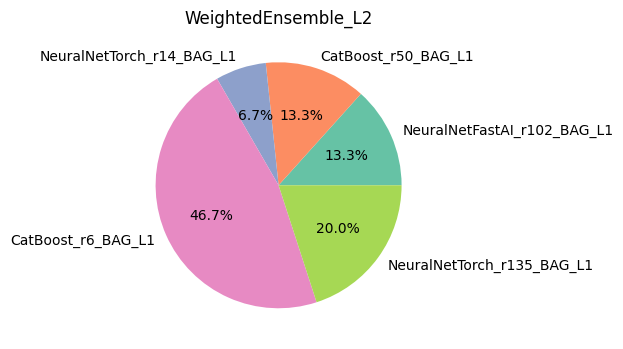

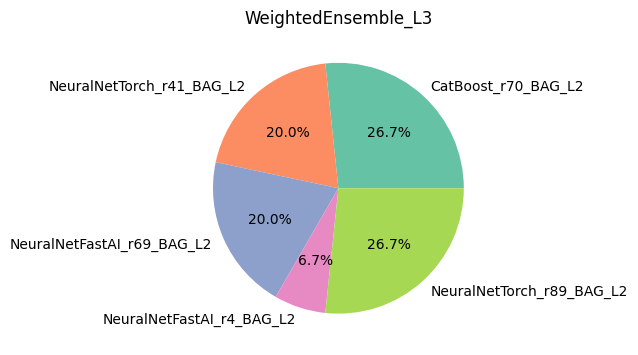

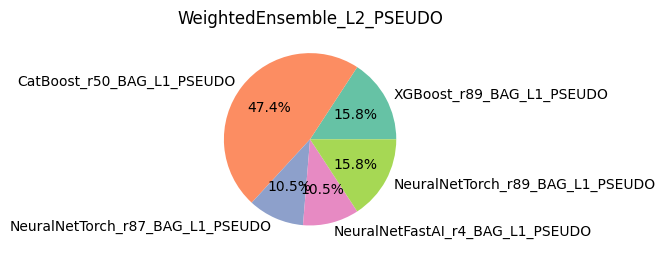

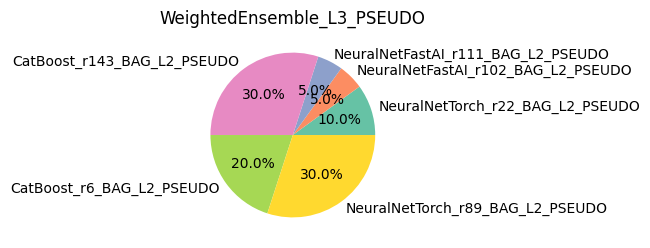

In [9]:
ensemble_weights, selected_models = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

In [10]:
predictor.leaderboard(silent=True)[predictor.leaderboard(silent=True).model.isin(selected_models)].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3_PSEUDO,0.909844,roc_auc,61.535590,3249.257376,0.000698,0.260899,3,True,444
1,WeightedEnsemble_L3,0.906462,roc_auc,47.190052,2497.589911,0.000696,0.240614,3,True,222
2,WeightedEnsemble_L2_PSEUDO,0.906022,roc_auc,0.472463,153.066481,0.000685,0.275906,2,True,334
3,CatBoost_r143_BAG_L2_PSEUDO,0.905659,roc_auc,59.789769,3004.307627,0.046313,29.129184,2,True,407
4,NeuralNetTorch_r89_BAG_L2_PSEUDO,0.905346,roc_auc,60.075463,3020.482649,0.332007,45.304205,2,True,443
6,CatBoost_r6_BAG_L2_PSEUDO,0.904606,roc_auc,59.795557,2994.948148,0.052101,19.769704,2,True,418
9,NeuralNetFastAI_r102_BAG_L2_PSEUDO,0.903890,roc_auc,60.301323,3050.724870,0.557867,75.546427,2,True,357
10,NeuralNetTorch_r22_BAG_L2_PSEUDO,0.903828,roc_auc,60.035119,3015.941259,0.291663,40.762815,2,True,353
13,CatBoost_r50_BAG_L1_PSEUDO,0.903131,roc_auc,0.025588,14.116782,0.025588,14.116782,1,True,256
17,WeightedEnsemble_L2,0.902516,roc_auc,0.618416,168.316141,0.000706,0.207659,2,True,112


# Collecting and saving OOF files

In [11]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = 'oof_pred_probs' if type == 'oof' else 'test_pred_probs'
    base_path = '.' if is_ensemble else base_path
    with open(f'{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_autogluon_{score:.6f}.csv', index=False)
    
os.makedirs('oof_pred_probs', exist_ok=True)
os.makedirs('test_pred_probs', exist_ok=True)

In [12]:
oof_pred_probs = {}
test_pred_probs = {}

In [13]:
overall_scores = {}
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_test_pred_probs = test_pred_probs[model].values[:, 1]
    
    cv_score = roc_auc_score(train[CFG.target], model_oof_pred_probs)
    overall_scores[model] = cv_score
    
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', False)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', True)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.

# Visualizing the results

In [14]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = roc_auc_score(train.loc[val_index, CFG.target], oof_pred_probs[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

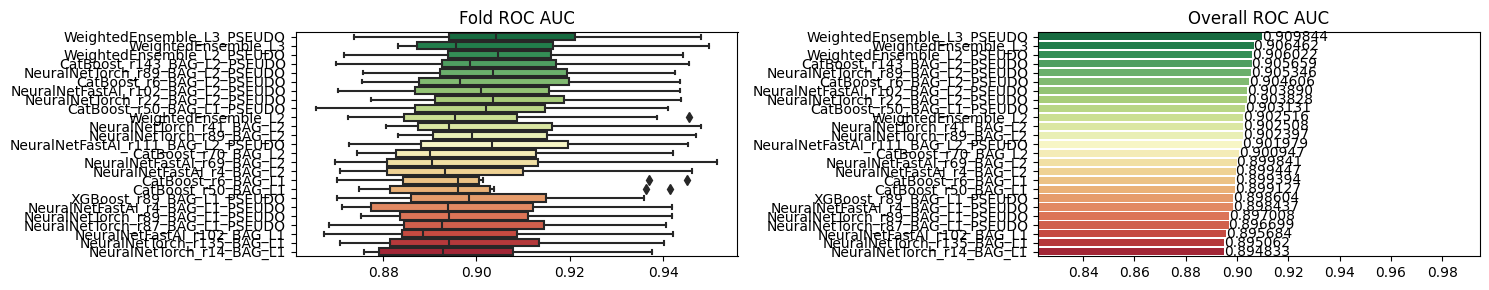

In [15]:
scores_df = pd.DataFrame(scores)[selected_models]
overall_scores_series = pd.Series({k: v for k, v in overall_scores.items()})[selected_models]
order = overall_scores_series.sort_values(ascending=False).index.tolist()

min_score = min(scores_df.min().min(), overall_scores_series.min())
max_score = max(scores_df.max().max(), overall_scores_series.max())
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, len(scores_df) * 0.3))

sns.boxplot(data=scores_df, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title("Fold ROC AUC")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=overall_scores_series, y=overall_scores_series.index, ax=axs[1], palette="RdYlGn_r", order=order)
axs[1].set_title("Overall ROC AUC")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(overall_scores_series[order]):
    barplot.text(score, i, f"{score:.6f}", va="center")

plt.tight_layout()
plt.show()